In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dstomp.framework import DSTOMP
from environment.gridworld import GridWorld
from environment.room_design import (
    larger_hallway_larger_room,
    larger_room,
    stomp_four_room_design,
)

In [2]:
num_runs = 5
all_runs = {"option_learning_logs": [], "model_learning_logs": [], "planning_logs": []}

In [3]:
for run in tqdm(range(num_runs)):
    print(f"Run {run + 1}/{num_runs}")
    env = GridWorld(larger_hallway_larger_room)
    dstomp = DSTOMP(
        env=env,
        num_subgoals=10,
        off_policy_steps_for_successor_representation=int(10e6),
    )

    env.reset()

    option_learning_logs, model_learning_logs, planning_logs = dstomp.execute(
        off_policy_steps=500_000, num_lookahead_operations=20_000
    )

    all_runs["option_learning_logs"].append(option_learning_logs)
    all_runs["model_learning_logs"].append(model_learning_logs)
    all_runs["planning_logs"].append(planning_logs)

  0%|          | 0/5 [00:00<?, ?it/s]

Run 1/5
[INFO] Starting DSTOMP execution...

[INFO] Finding bottleneck states using Successor Representation


100%|██████████| 10000000/10000000 [01:55<00:00, 86409.97it/s]



[INFO] Learning options for subgoal 1/10


100%|██████████| 500000/500000 [00:24<00:00, 20444.36it/s]



[INFO] Learning options for subgoal 2/10


100%|██████████| 500000/500000 [00:24<00:00, 20702.76it/s]



[INFO] Learning options for subgoal 3/10


100%|██████████| 500000/500000 [00:24<00:00, 20405.31it/s]



[INFO] Learning options for subgoal 4/10


100%|██████████| 500000/500000 [00:24<00:00, 20555.58it/s]



[INFO] Learning options for subgoal 5/10


100%|██████████| 500000/500000 [00:24<00:00, 20690.17it/s]



[INFO] Learning options for subgoal 6/10


100%|██████████| 500000/500000 [00:24<00:00, 20470.01it/s]



[INFO] Learning options for subgoal 7/10


100%|██████████| 500000/500000 [00:24<00:00, 20538.37it/s]



[INFO] Learning options for subgoal 8/10


100%|██████████| 500000/500000 [00:24<00:00, 20290.70it/s]



[INFO] Learning options for subgoal 9/10


100%|██████████| 500000/500000 [00:24<00:00, 20704.85it/s]



[INFO] Learning options for subgoal 10/10


100%|██████████| 500000/500000 [00:24<00:00, 20602.08it/s]



[INFO] Learning model for option 1/14, a Primitive Action 



100%|██████████| 500000/500000 [2:22:09<00:00, 58.62it/s] 



[INFO] Learning model for option 2/14, a Primitive Action 



100%|██████████| 500000/500000 [3:00:15<00:00, 46.23it/s] 



[INFO] Learning model for option 3/14, a Primitive Action 



100%|██████████| 500000/500000 [1:42:13<00:00, 81.52it/s] 



[INFO] Learning model for option 4/14, a Primitive Action 



100%|██████████| 500000/500000 [29:11<00:00, 285.49it/s]



[INFO] Learning model for option 5/14, a Full Option 



100%|██████████| 500000/500000 [1:31:05<00:00, 91.48it/s] 



[INFO] Learning model for option 6/14, a Full Option 



100%|██████████| 500000/500000 [29:15<00:00, 284.81it/s]



[INFO] Learning model for option 7/14, a Full Option 



100%|██████████| 500000/500000 [1:46:29<00:00, 78.25it/s] 



[INFO] Learning model for option 8/14, a Full Option 



100%|██████████| 500000/500000 [1:40:08<00:00, 83.21it/s] 



[INFO] Learning model for option 9/14, a Full Option 



100%|██████████| 500000/500000 [1:03:50<00:00, 130.53it/s]



[INFO] Learning model for option 10/14, a Full Option 



100%|██████████| 500000/500000 [1:12:13<00:00, 115.37it/s]



[INFO] Learning model for option 11/14, a Full Option 



100%|██████████| 500000/500000 [29:16<00:00, 284.70it/s]



[INFO] Learning model for option 12/14, a Full Option 



100%|██████████| 500000/500000 [1:05:56<00:00, 126.39it/s]



[INFO] Learning model for option 13/14, a Full Option 



100%|██████████| 500000/500000 [29:49<00:00, 279.33it/s]



[INFO] Learning model for option 14/14, a Full Option 



100%|██████████| 500000/500000 [29:55<00:00, 278.42it/s]



[INFO] Planning with learned options and models...



 20%|██        | 1/5 [17:58:00<71:52:02, 64680.61s/it]

Run 2/5
[INFO] Starting DSTOMP execution...

[INFO] Finding bottleneck states using Successor Representation


100%|██████████| 10000000/10000000 [01:56<00:00, 86128.34it/s]



[INFO] Learning options for subgoal 1/10


100%|██████████| 500000/500000 [00:24<00:00, 20170.27it/s]



[INFO] Learning options for subgoal 2/10


100%|██████████| 500000/500000 [00:24<00:00, 20421.81it/s]



[INFO] Learning options for subgoal 3/10


100%|██████████| 500000/500000 [00:24<00:00, 20351.55it/s]



[INFO] Learning options for subgoal 4/10


100%|██████████| 500000/500000 [00:24<00:00, 20411.44it/s]



[INFO] Learning options for subgoal 5/10


100%|██████████| 500000/500000 [00:24<00:00, 20587.09it/s]



[INFO] Learning options for subgoal 6/10


100%|██████████| 500000/500000 [00:24<00:00, 20224.49it/s]



[INFO] Learning options for subgoal 7/10


100%|██████████| 500000/500000 [00:24<00:00, 20455.36it/s]



[INFO] Learning options for subgoal 8/10


100%|██████████| 500000/500000 [00:24<00:00, 20551.33it/s]



[INFO] Learning options for subgoal 9/10


100%|██████████| 500000/500000 [00:24<00:00, 20395.15it/s]



[INFO] Learning options for subgoal 10/10


100%|██████████| 500000/500000 [00:24<00:00, 20267.11it/s]



[INFO] Learning model for option 1/14, a Primitive Action 



 20%|██        | 1/5 [18:17:28<73:09:53, 65848.49s/it]


KeyboardInterrupt: 

In [ ]:
planning_mean = np.mean(all_runs["planning_logs"], axis=0)
planning_std = np.std(all_runs["planning_logs"], axis=0)

In [ ]:
def plot_arrays(mean_array, std_array, plotting_info):
    # Create figure and axis
    plt.figure(figsize=(20, 6))

    # Generate x-axis points (assuming these are sequential steps/episodes)
    x = np.arange(len(mean_array))

    # Plot mean line with shaded standard deviation
    plt.plot(x, mean_array, "b-", label="Mean")
    plt.fill_between(
        x,
        mean_array - std_array,
        mean_array + std_array,
        color="b",
        alpha=0.2,
        label="Standard Deviation",
    )

    # Customize the plot
    plt.xlabel(plotting_info["xlabel"])
    plt.ylabel(f"{plotting_info['ylabel']}\n(Average Over 100 runs)")
    plt.title(plotting_info["title"])
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
plot_arrays(
    planning_mean,
    planning_std,
    {
        "xlabel": "Number of Planning Look-ahead Operations",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "Planning with Options",
    },
)

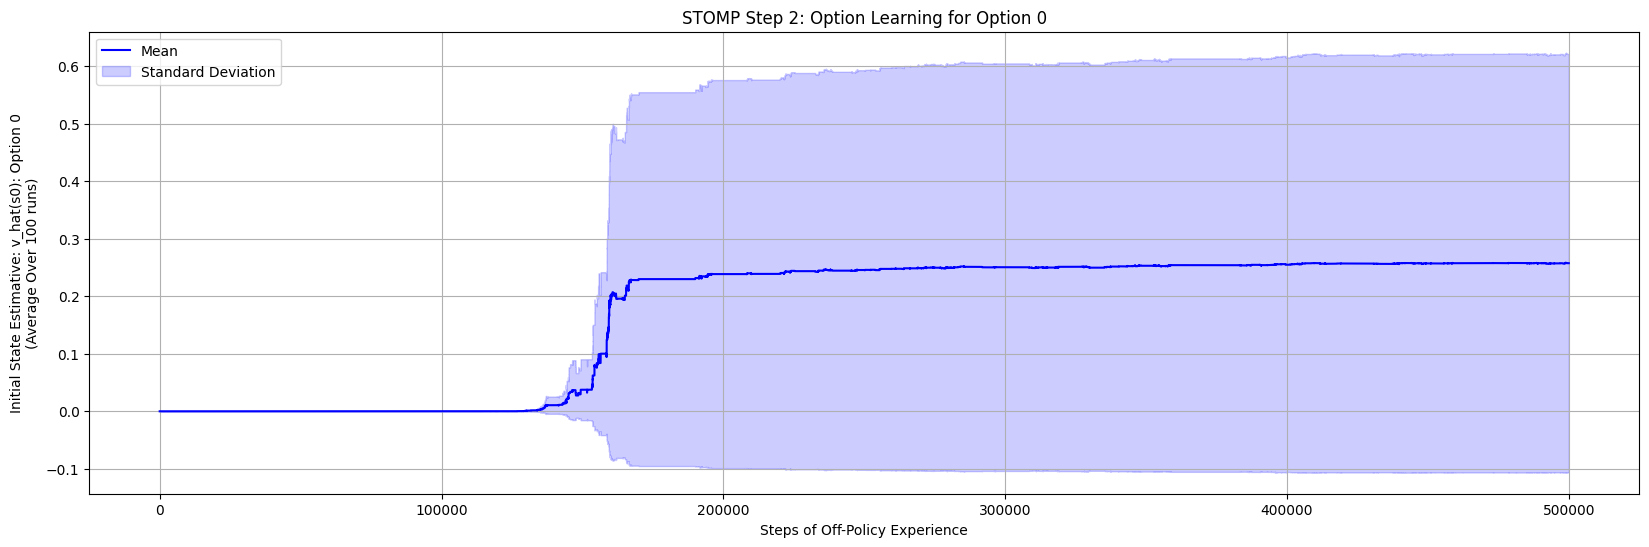

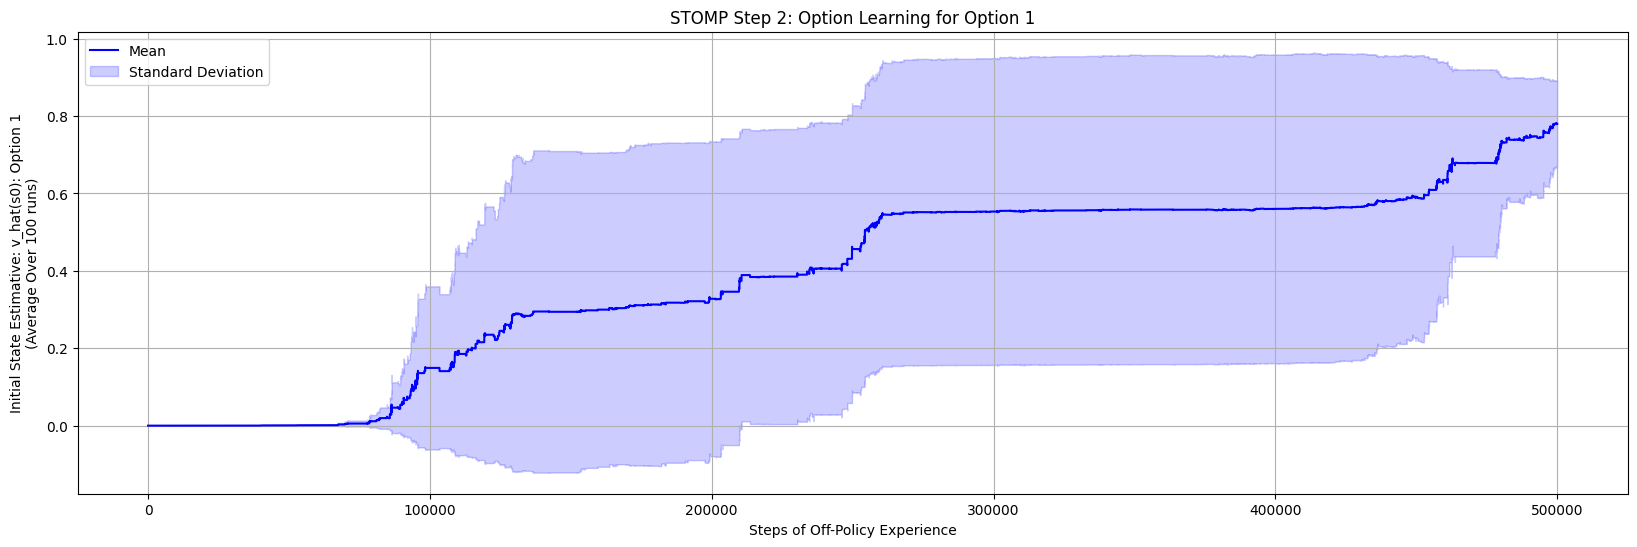

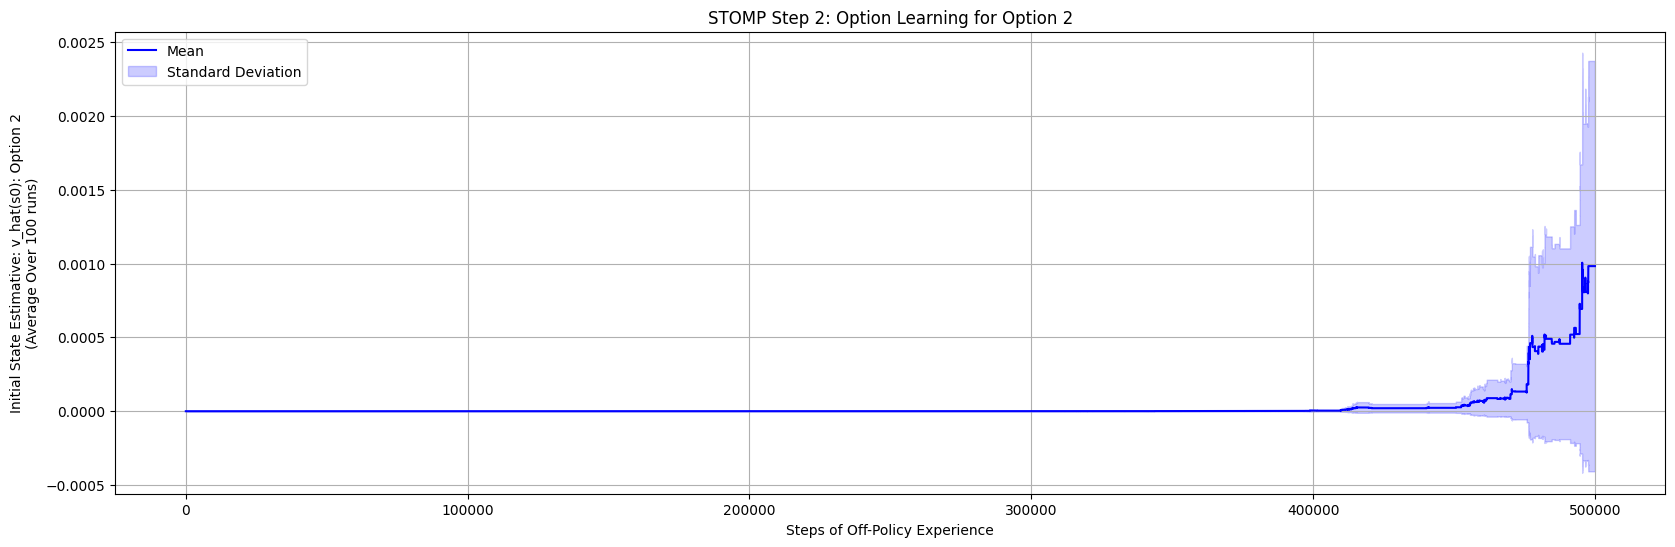

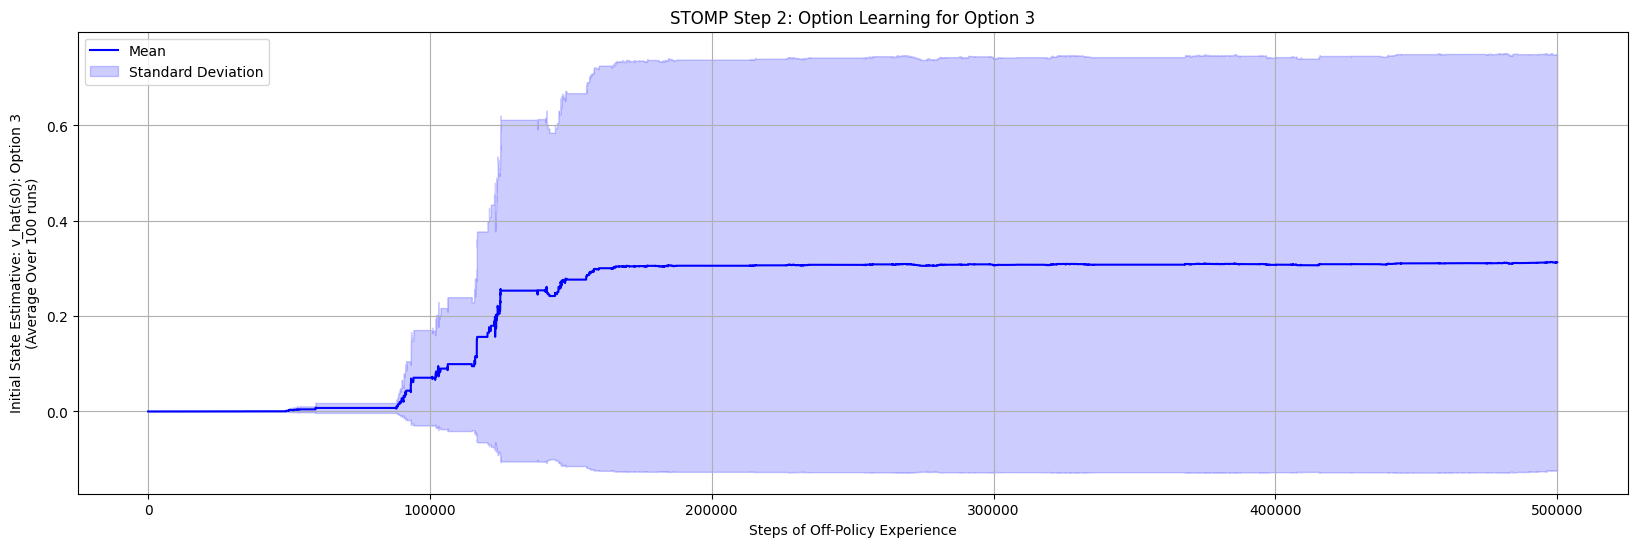

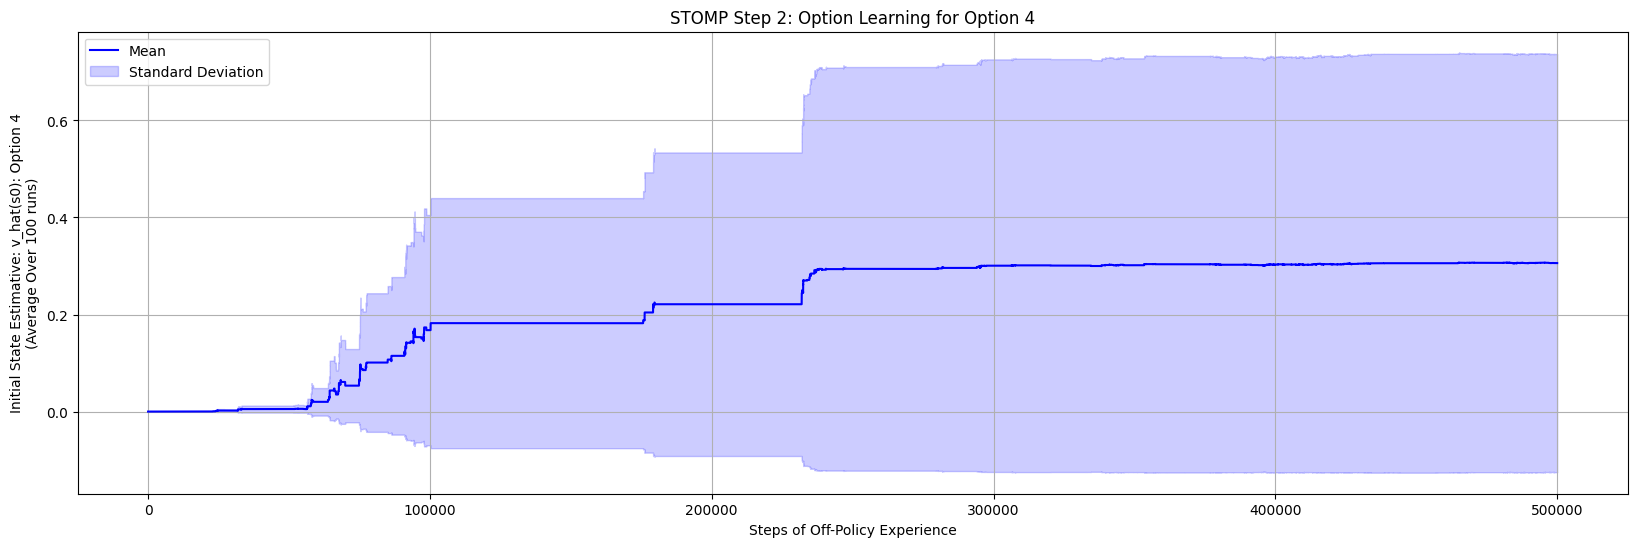

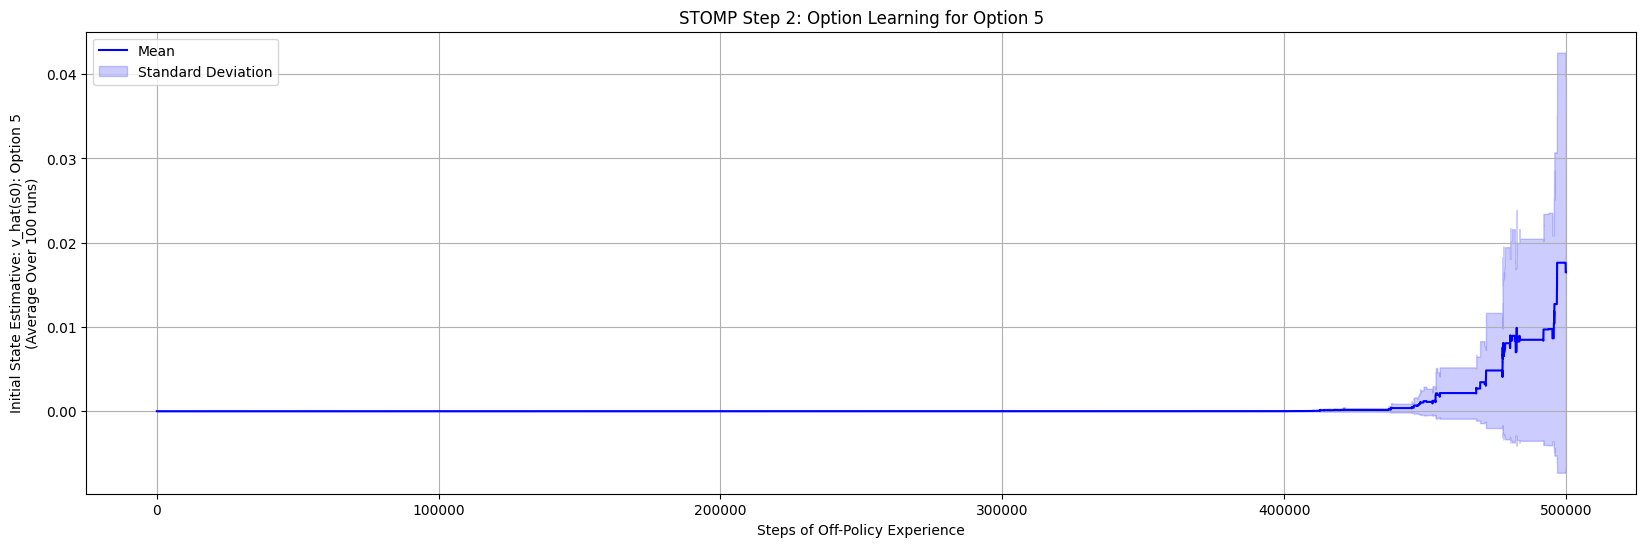

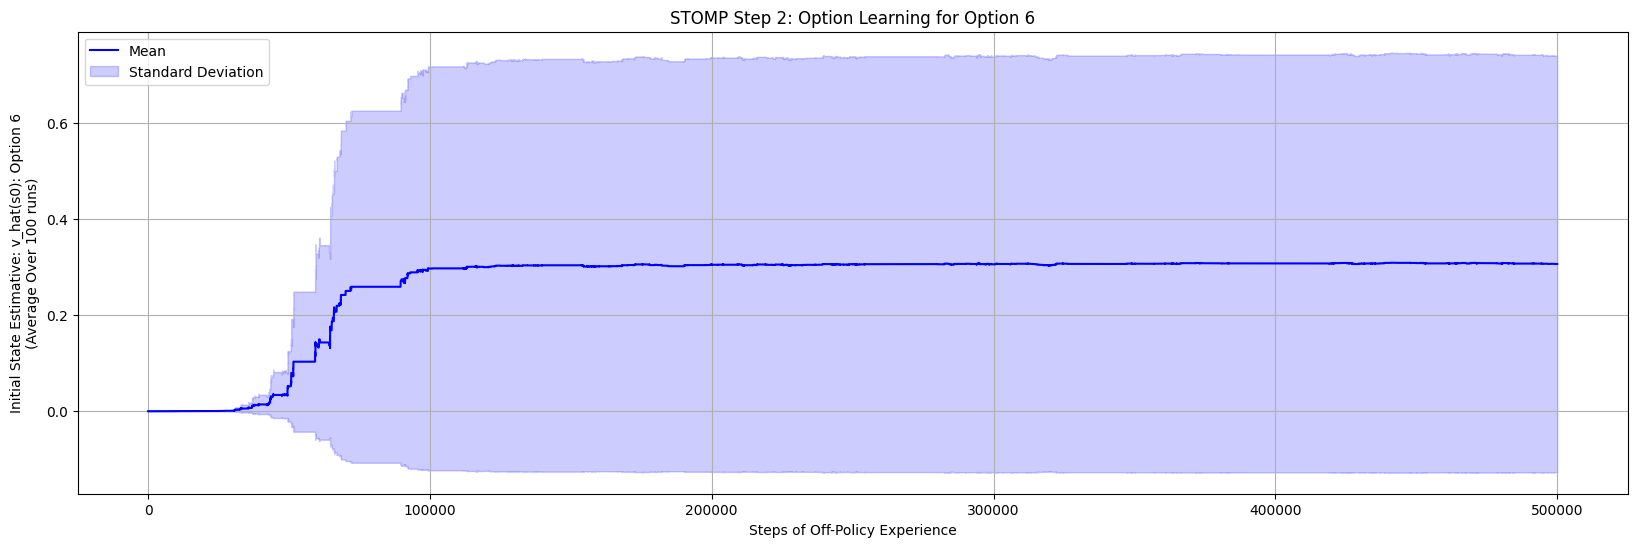

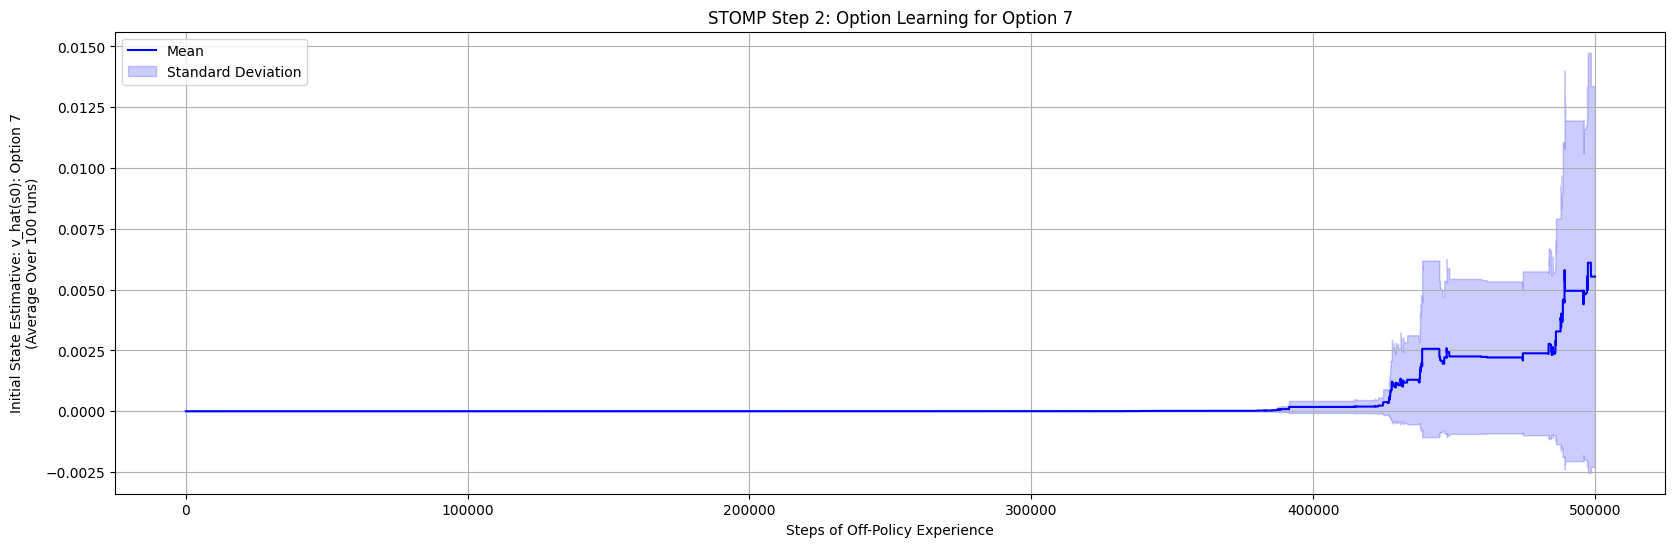

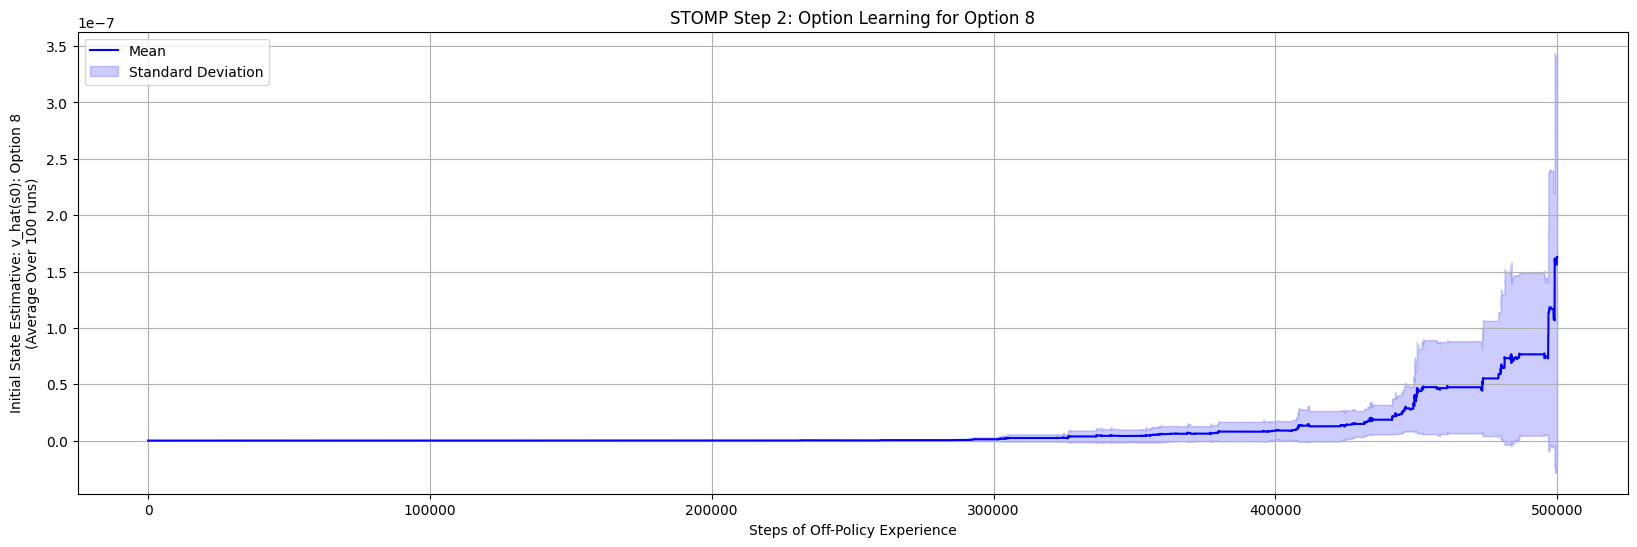

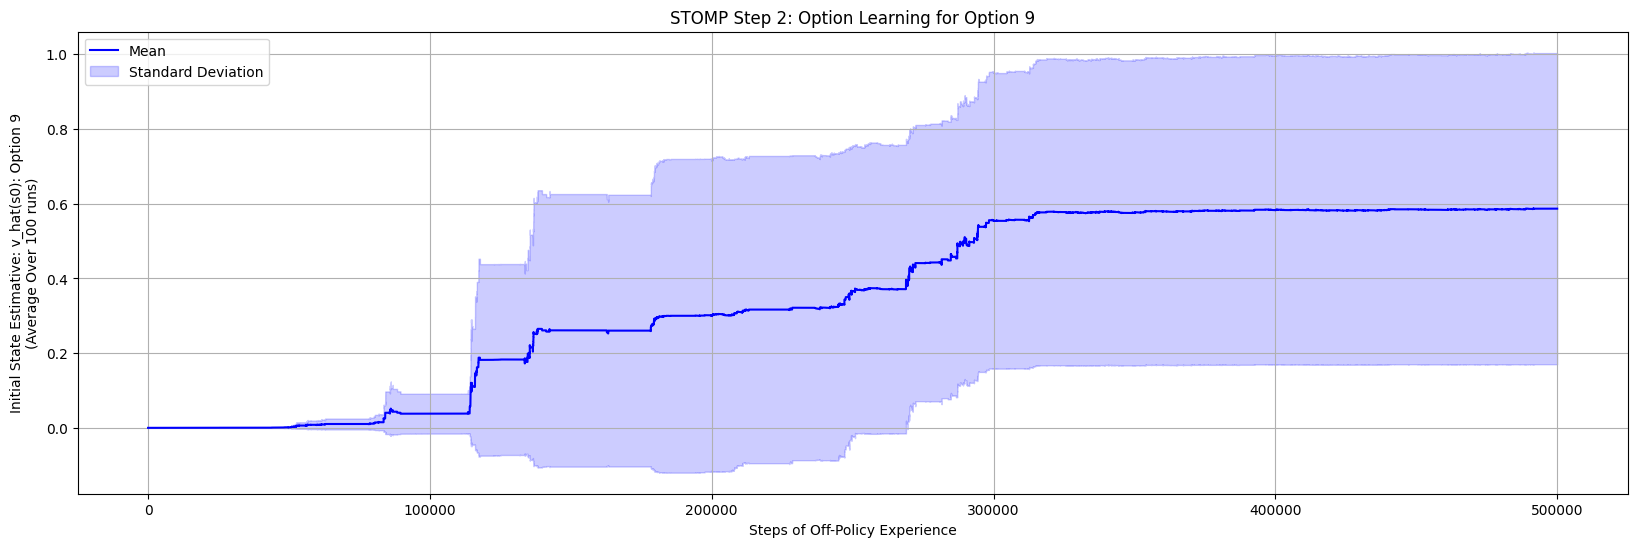

In [ ]:
for i in range(len(planning_mean)):
    plot_arrays(
        learning_options_mean[i],
        learning_options_std[i],
        {
            "xlabel": "Steps of Off-Policy Experience",
            "ylabel": f"Initial State Estimative: v_hat(s0): Option {i}",
            "title": f"STOMP Step 2: Option Learning for Option {i}",
        },
    )

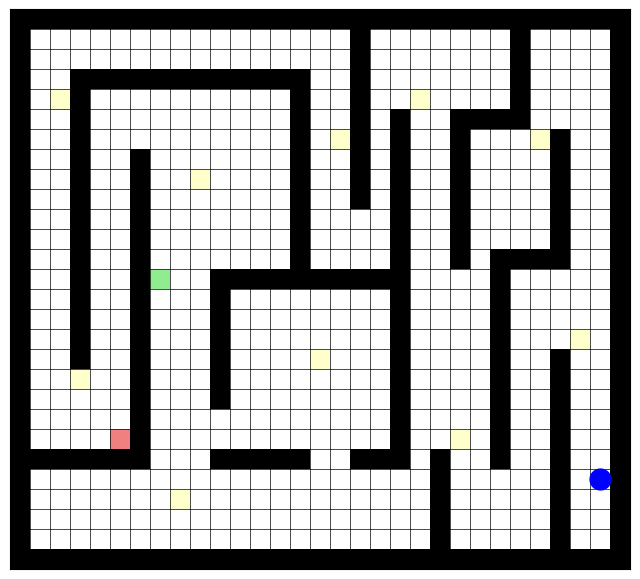

In [ ]:
env.plot_room()

In [ ]:
np.choose(list(env.state_coordinates_to_idx.keys()))

[(1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (16, 2),
 (18, 2),
 (19, 2),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 2),
 (24, 2),
 (26, 2),
 (27, 2),
 (28, 2),
 (29, 2),
 (1, 3),
 (2, 3),
 (15, 3),
 (16, 3),
 (18, 3),
 (19, 3),
 (20, 3),
 (21, 3),
 (22, 3),
 (23, 3),
 (24, 3),
 (26, 3),
 (27, 3),
 (28, 3),
 (29, 3),
 (1, 4),
 (2, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (7, 4),
 (8, 4),
 (9, 4),
 (10, 4),
 (11, 4),
 (12, 4),
 (13, 4),
 (15, 4),
 (16, 4),
 (18, 4),
 (19, 4),
 (20, 4),
 (21, 4),
 (22, 4),
 (23, 4),
 (24, 4),
 (26, 4),
 (27, 4),
 (28, 4),
 (29, 4),
 (1, 5),
 (2, 5),
 (4, 5),
 (5, 5),
 (6, 5),
 (7, 5),
 (8, 5),
 (9, 5),
 (10, 5),
 (11, 

In [ ]:
import random

random.choice(list(env.state_coordinates_to_idx.keys()))

(10, 11)

In [ ]:
np.random.choice(list(env.state_coordinates_to_idx.keys()))

ValueError: a must be 1-dimensional